In [63]:
# when importing the new dataset, compare this one with median prices to the zillow estimate 

In [64]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [65]:
def stationarity_check(df):
    
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

In [66]:
"""
Grid search for best pdq value based on aic 
return two tuples containing optimal pdq and pdqs values for fitting in SARIMAX model 
"""
def get_pdqs(df, test, seasonal=12, optimize='aic', display=True):   

    # p d and q can be 0, 1 or 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p (autogressive terms), d (differencing), and q (moving average terms)
    pdq = list(itertools.product(p, d, q))
    
    # do the same with seasonal 
    # default 12: this data has a yearly seasonal component  
    pdqs = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

    # Takes the permutations above and runs a grid search to find the model with the lowest AIC score 
    output = []
    for combo in pdq:
        for combo_seasonal in pdqs:
            try:
                results = train_sarimax(df, pdq=combo, PDQS=combo_seasonal, summary=False)
#                 train, test =  split_train_test(df) # get the test 
                dynamic_rmse = test_dynamic_predictions(results, test, display=False) 
                
                output.append([combo, combo_seasonal, results.aic, dynamic_rmse]) 
            
                if display:
                    print(f'pdq: {combo}; pdqs: {combo_seasonal}, AIC: {results.aic}, RMSE: {dynamic_rmse}')
            except:
                continue
            
    # Find the parameters with minimal AIC value
    output_df = pd.DataFrame(output, columns=['pdq', 'pdqs', 'aic','dynamic_rmse']) 
    
    if optimize == 'dynamic_rmse':
        pdq = tuple(output_df[output_df.dynamic_rmse == output_df.dynamic_rmse.min()]['pdq'].values[0])
        PDQS = tuple(output_df[output_df.dynamic_rmse == output_df.dynamic_rmse.min()]['pdqs'].values[0])
    elif optimize == 'aic':
        pdq = tuple(output_df[output_df.aic == output_df.aic.min()]['pdq'].values[0])
        PDQS = tuple(output_df[output_df.aic == output_df.aic.min()]['pdqs'].values[0])
    else:
        print('Please specify one of the following optimize parameters [aic, rmse].')

    return output_df, pdq, PDQS 

In [67]:
def train_sarimax(df, pdq=(0,2,2), PDQS=(0,0,0,12), summary=False, diagnostics=False):
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                                          enforce_stationarity=True, 
                                          enforce_invertibility=True)
    
    try:
        results = arima_mod.fit(maxiter=250)
        if results.llf == 0.0: 
            print('Error. Log likelihood 0')
            results = train_sarimax_non_enforced(df, pdq=pdq, PDQS=PDQS)
    except:
        print('Error. Couldn\'t train model. Training without invertibility enforcement')
        results = train_sarimax_non_enforced(df, pdq=pdq, PDQS=PDQS)
        return results  
    
    if summary:
        print(results.summary())
    
    if diagnostics:
        results.plot_diagnostics(figsize=(14,10))
    
    return results 

In [68]:
def train_sarimax_non_enforced(df, pdq=(0,2,2), PDQS=(0,0,0,12)):
    
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                          enforce_stationarity=True, 
                          enforce_invertibility=False)
    results = arima_mod.fit(maxiter=250)
    
    return results 

In [69]:
""" 
takes in string and splits data
date entered is included in the train data 
"""
def split_train_test(df, split='2015-03-01'):
    return df.loc[:split], df.loc[pd.to_datetime(split) + pd.DateOffset(months=1):]

In [70]:
def train_results_rmse(results, train, period=24, display=True):
    # predict going back from 2 years, or other time specified 
    train_predict = results.predict(-period)
    
    # visualize results, plot train vs. predicted values 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        train.plot(ax=ax, label='train actual')
        # plot one step ahead predictions 
        train_predict.plot(ax=ax, style='r--', label='one step ahead forecast')
        legend=ax.legend(loc='lower right')

    rmse_ = np.sqrt(mean_squared_error(train_predict, train[-period:])) 
    
    if display:
        print(f'\nTraining RMSE: {rmse_}')
    
    return rmse_ 

In [71]:
# walk forward validation on test data 
# return RMSE 
def test_results_rmse(train, test, pdq=(1,1,1), PDQS=(1,1,1,12), display=True):

    # walk-forward validation
    predictions=[]
    history = [x for x in train.values]
    actuals = test.values

    for t in range(len(test)):
        try:
            results = train_sarimax(history, pdq=pdq, PDQS=PDQS, summary=False)
        except:
            print('could not train.')

        output=results.forecast()
        y_hat = output[0]
        predictions.append(y_hat)
        actual = actuals[t]
        history.append(actual)
        #print('predicted: {}, expected: {}'.format(y_hat, actual))
    
    # convert predictions from list to series so rmse can be calculated 
    predictions = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
     
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='predictions')
        legend=ax.legend(loc='lower right')
        plt.title('Walk Forward Test Validation')
        plt.show()
        print(f'Test RMSE: {rmse}')

    return rmse

In [72]:
# dynamic predictions on test data using results 
# return RMSE 
def test_dynamic_predictions(results, test, display=True):
    # dynamic prediction 
    dynamic_pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)
    predictions = dynamic_pred.predicted_mean
    actuals = test.values 
    pred_ci = dynamic_pred.conf_int()
    
    # visualize test vs. dynamic predictions 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
    #     plt.plot(train['2014-01-01':], label='training')
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='dynamic forecast')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('Test Dynamic Forecast vs. Test Actuals')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    # get the rmse and return 
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    if display:
        print(f'RMSE: {rmse}')
    
    return rmse 

In [73]:
def forecast_results(df, pdq=(1,1,1), PDQS=(1,1,1,12), years=[1,3,5,10], display=False):
    
    # retrain new model on all data
    results = train_sarimax(df, pdq=pdq, PDQS=PDQS)
    
    # get the last date in the data
    start_date = df.index[-1]
    
    forecasted_prices = []
    forecasted_rois = []

    for yr in [1,3,5,10]:
        # get the actual current price  
        current_actual = df.loc[start_date] 
        
        # add yr to the current date 
        end_date = start_date + pd.DateOffset(years=yr)
        
        # get dynamic predictions, values and the final prediction at the end of the series 
        dynamic_pred = results.get_prediction(start=start_date, end=end_date)
        predictions = dynamic_pred.predicted_mean 
        final_prediction = predictions[-1]
        
        # add the forecasted price after yr to the list 
        forecasted_prices.append(final_prediction) 
        
        # get confidence interval 
        pred_ci = dynamic_pred.conf_int()

        # get the ROI multiple 
        roi = (final_prediction - current_actual)/current_actual 
        forecasted_rois.append(roi)
        
        if display:
            print(f'Current price: ${current_actual}, Price after {yr} year(s): ${final_prediction.round(2)}')
            print(f'ROI for {yr} year(s):{roi}\n')
    
    if display:
        # plot 10 years of predictions 
        fig,ax=plt.subplots(figsize=(12,5))
        predictions.plot(ax=ax, label='test actuals')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('10 Year Forecast')
        legend=ax.legend(loc='lower right')
        plt.show()
        
    return forecasted_prices, forecasted_rois
    

In [74]:
def organize_results(current_zip, output_df_, train_results_, test_results_, forecasted_prices_, forecasted_rois_):

#     output_df = output_df_.sort_values(by='aic', ascending=True)

    # create new dataframe with results 
    df = pd.DataFrame(output_df.iloc[0]).T
    df['train_rmse'] = train_results_
    df['test_rmse'] = test_results_
    
    # add new columns for each forecasted price and ROI 
    for price, yr in zip(forecasted_prices_, [1,3,5,10]):
        df[f'forecast_{yr}yr_price'] = price

    for roi, yr in zip(forecasted_rois_, [1,3,5,10]):
        df[f'forecast_{yr}yr_roi'] = roi
    
    df['zip'] = current_zip
    
    return df

In [75]:
def get_nj(df):
    
    nj = df[df.State == 'NJ']
    missing = nj.isna().sum().values.sum() 
    
    if missing > 0:
        print('{missing} missing values.')
        return False 
    else: 
        print('{} unique zip codes in NJ'.format(nj.RegionName.nunique()))
        return nj 

In [76]:
def melt_df(df):
    melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     print(f'{len(melted)} zip codes')
    
    if melted.isna().sum().values.sum() > 0:
        print('missing values present.')
    
    df = melted[['RegionName','SizeRank','City','Metro','CountyName','time','value']].rename(columns={'RegionName':'zip',
                                                                                                      'value':'price',
                                                                                                      'SizeRank':'size_rank',
                                                                                                      'City':'city',
                                                                                                      'Metro':'metro',
                                                                                                      'CountyName':'county'}).set_index('time')
    
    return df 

In [77]:
def acf_pacf(df, nlags=36):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    plot_acf(nj_avg_m, ax=ax[0], lags=nlags)
    plot_pacf(nj_avg_m, ax=ax[1], lags=nlags)
    plt.show()

In [78]:
data = pd.read_csv('zillow_data.csv')
sns.set_style('darkgrid')


In [79]:
nj = get_nj(data)
df = melt_df(nj)
df.head()

502 unique zip codes in NJ


,zip,size_rank,city,metro,county,price
time,,,,,,
1996-04-01,7030,58,Hoboken,New York,Hudson,301600.0
1996-04-01,8701,74,Lakewood,New York,Ocean,153800.0
1996-04-01,8753,159,Toms River,New York,Ocean,123400.0
1996-04-01,7002,188,Bayonne,New York,Hudson,145000.0
1996-04-01,7302,192,Jersey City,New York,Hudson,137200.0


## Overall NJ Analysis 

In [80]:
nj_avg = df[['price']].groupby('time').price.median().reset_index().set_index('time')
nj_avg = nj_avg.asfreq('MS')
nj_avg

,price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


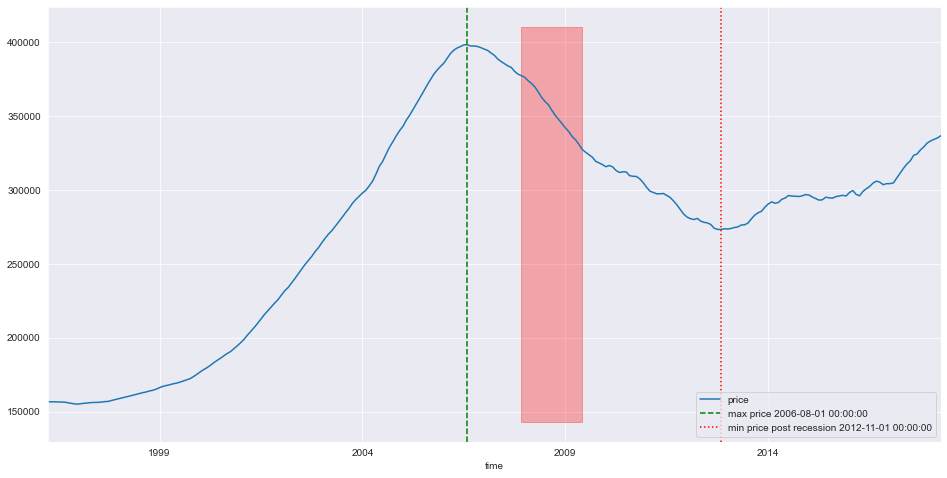

In [81]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Recession = December 2007 – June 2009
# TODO Fix 
fig,ax = plt.subplots(figsize=(16,8))
nj_avg.plot(ax=ax, label='median house prices')
recession = nj_avg.loc['2007-12-01':'2009-06-01']
min_recession = nj_avg.loc['2008':'2014'].price.idxmin()
max_overall = nj_avg.price.idxmax()

ax.fill_between(recession.index, ax.get_ylim()[0], ax.get_ylim()[1], color='red', alpha=0.3)
# plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
ax.axvline(max_overall, ls='--', color = 'g', label=f'max price {max_overall}')
ax.axvline(min_recession, ls=':', color = 'r', label=f'min price post recession {min_recession}')

legend=ax.legend(loc='lower right')

# years = np.arange(1996,2019,1)
# print(ax.get_xticklabels())
# print(years)
plt.show()

In [82]:
# not full years in 96 and 2018 
year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
temp_annual = pd.DataFrame()
for yr, group in year_groups:
    temp_annual[yr.year] = group.values.ravel()
# temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
# plt.show()

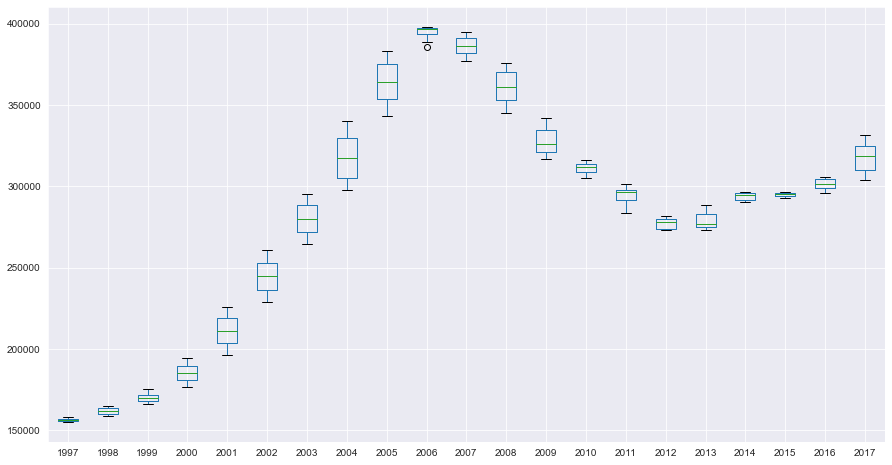

In [83]:
temp_annual.boxplot(figsize=(15,8))
plt.show()

In [84]:
nj_avg_m = nj_avg.resample('MS').sum()
nj_avg_m = nj_avg_m['2012':]

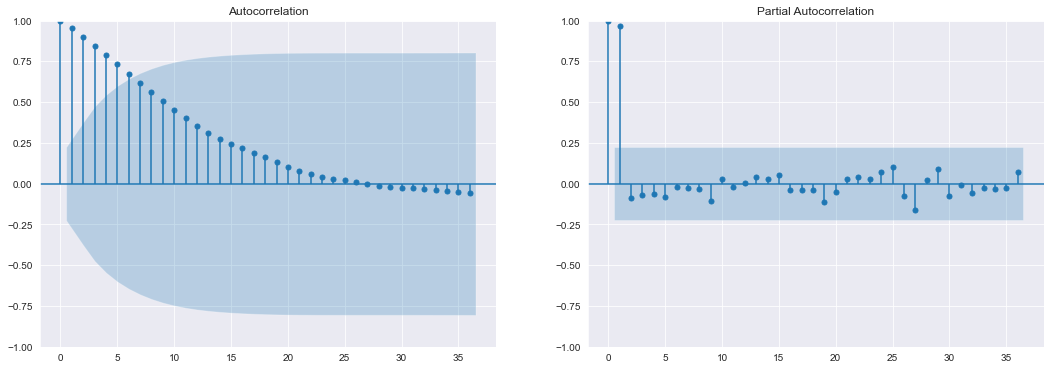

In [85]:
acf_pacf(nj_avg_m)

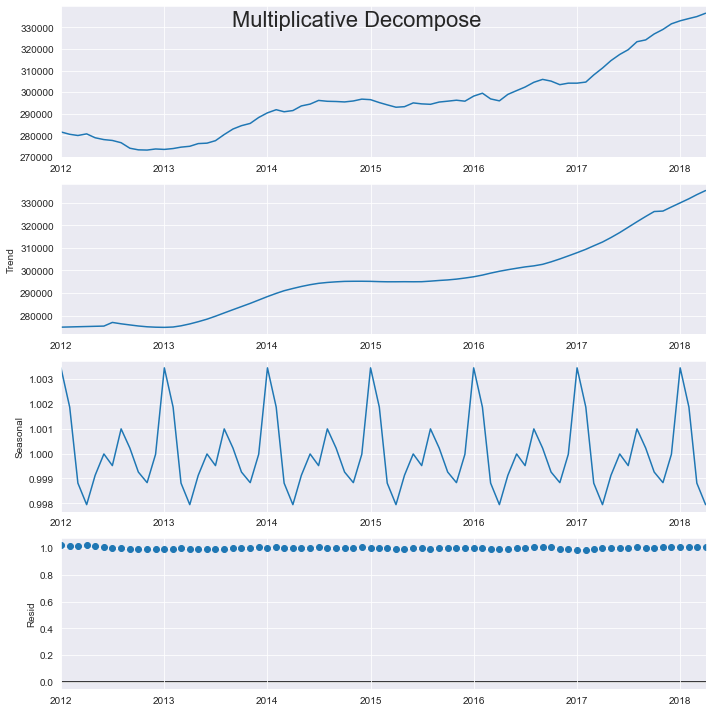

In [86]:
result_add = seasonal_decompose(nj_avg_m, model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.show()

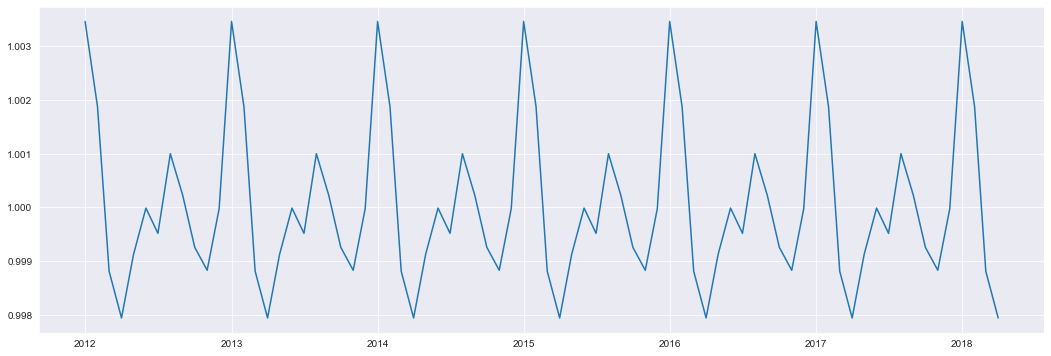

In [87]:
plt.figure(figsize=(18,6))
# TODO add dotted lines 
plt.plot(result_add.seasonal)
plt.show()

In [88]:
# split into training and test data 
train, test = split_train_test(nj_avg_m)

In [89]:
# get PDQS
output_df, pdq, PDQS = get_pdqs(nj_avg_m, test) 
output_df

pdq: (0, 0, 0); pdqs: (0, 0, 0, 12), AIC: 2132.9454555409943, RMSE: 309032.8597065017
pdq: (0, 0, 0); pdqs: (0, 0, 1, 12), AIC: 2099.958325602297, RMSE: 276493.5320076647
pdq: (0, 0, 0); pdqs: (0, 1, 0, 12), AIC: 1398.542438004412, RMSE: 19623.71187027489
pdq: (0, 0, 0); pdqs: (0, 1, 1, 12), AIC: 1405.7435869520832, RMSE: 19563.469043826553
pdq: (0, 0, 0); pdqs: (1, 0, 0, 12), AIC: 1737.0583881437467, RMSE: 20192.264844714668
pdq: (0, 0, 0); pdqs: (1, 0, 1, 12), AIC: 1742.9567660923553, RMSE: 20389.719805091645
pdq: (0, 0, 0); pdqs: (1, 1, 0, 12), AIC: 1399.692293949773, RMSE: 19555.676354969415
pdq: (0, 0, 0); pdqs: (1, 1, 1, 12), AIC: 1362.3445116464088, RMSE: 9016.973352503925
pdq: (0, 0, 1); pdqs: (0, 0, 0, 12), AIC: 2081.866673008911, RMSE: 306231.8516779673
pdq: (0, 0, 1); pdqs: (0, 0, 1, 12), AIC: 2076.573990078955, RMSE: 280539.4785261888
pdq: (0, 0, 1); pdqs: (0, 1, 0, 12), AIC: 1395.0622482433646, RMSE: 19591.875303701345
pdq: (0, 0, 1); pdqs: (0, 1, 1, 12), AIC: 1397.0583886

,pdq,pdqs,aic,dynamic_rmse
0,"(0, 0, 0)","(0, 0, 0, 12)",2132.945456,309032.859707
1,"(0, 0, 0)","(0, 0, 1, 12)",2099.958326,276493.532008
2,"(0, 0, 0)","(0, 1, 0, 12)",1398.542438,19623.711870
3,"(0, 0, 0)","(0, 1, 1, 12)",1405.743587,19563.469044
4,"(0, 0, 0)","(1, 0, 0, 12)",1737.058388,20192.264845
...,...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",1145.008657,10911.649374
60,"(1, 1, 1)","(1, 0, 0, 12)",1341.653375,20226.492412
61,"(1, 1, 1)","(1, 0, 1, 12)",1339.688186,18694.438630
62,"(1, 1, 1)","(1, 1, 0, 12)",1144.967237,10919.240124


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   39
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -232.414
Date:                            Sat, 19 Mar 2022   AIC                            474.828
Time:                                    10:32:24   BIC                            481.118
Sample:                                01-01-2012   HQIC                           476.639
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8870      0.070     12.734      0.000       0.750       1.024
ma.L1         -0.9043      0.066   

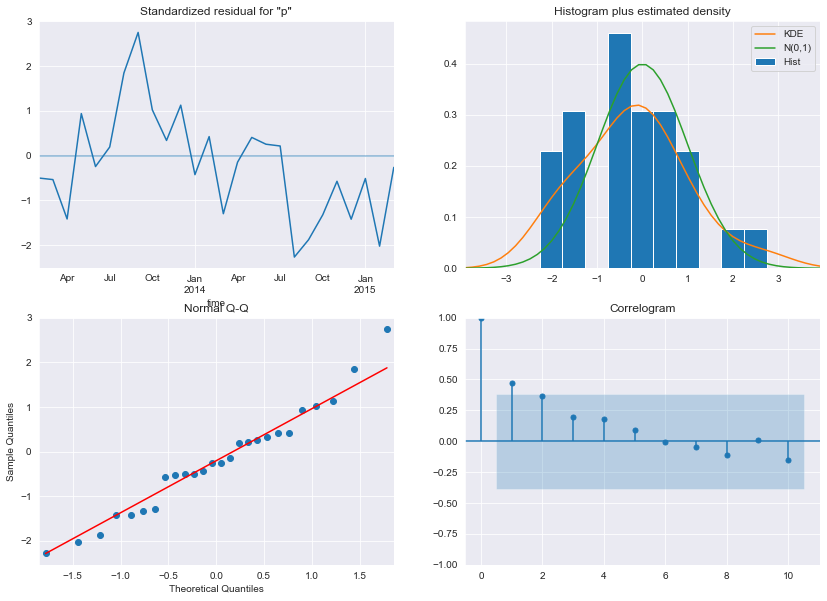

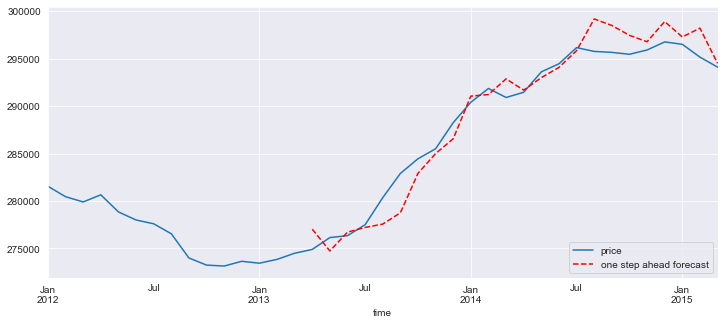

In [90]:
results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=True, diagnostics=True)
print('\n')
rmse = train_results_rmse(results, train, display=True)

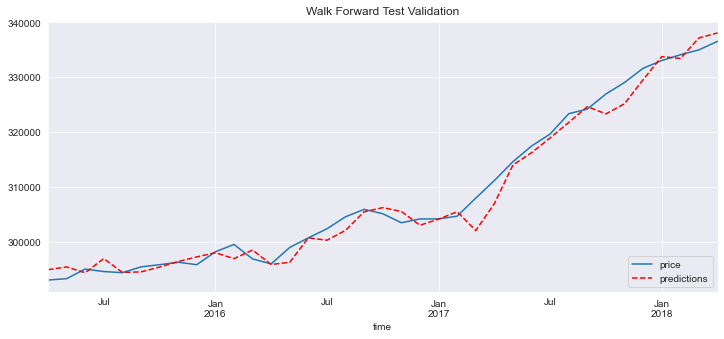

Test RMSE: 2016.9516182776092


2016.9516182776092

In [91]:
test_results_rmse(train, test, pdq=pdq, PDQS=PDQS)

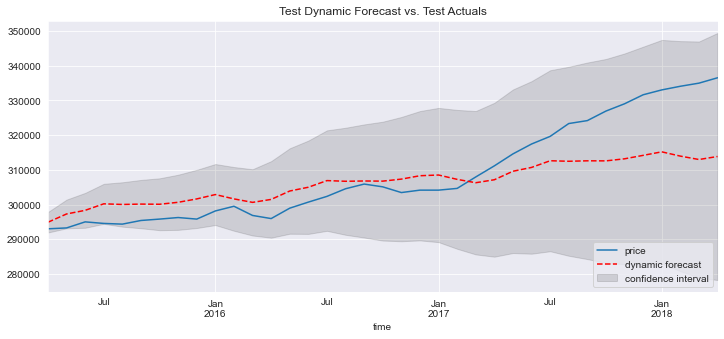

RMSE: 9400.345050242297


9400.345050242297

In [92]:
# dynamic prediction 
test_dynamic_predictions(results, test)

Current price: $336550.0, Price after 1 year(s): $359546.93
ROI for 1 year(s):0.06833139181531644

Current price: $336550.0, Price after 3 year(s): $407164.37
ROI for 3 year(s):0.20981836189912628

Current price: $336550.0, Price after 5 year(s): $454729.98
ROI for 5 year(s):0.35115132928668563

Current price: $336550.0, Price after 10 year(s): $574061.53
ROI for 10 year(s):0.7057243611733979



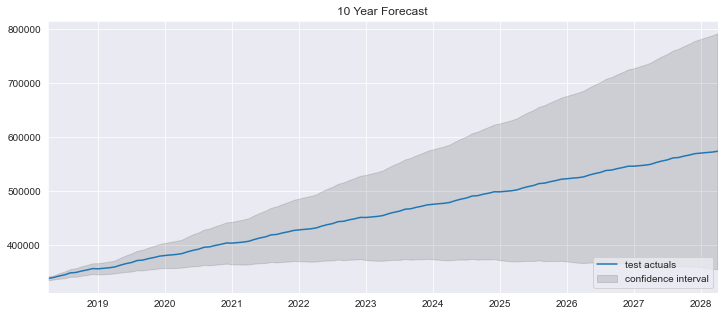

([359546.92991544475,
  407164.36969715095,
  454729.97987143404,
  574061.5337529071],
 [0.06833139181531644,
  0.20981836189912628,
  0.35115132928668563,
  0.7057243611733979])

In [93]:
forecast_results(nj_avg_m['price'], pdq=pdq, PDQS=PDQS,display=True)

## Get top 25 zip codes 

Investor Profile: 
Only interested in suburban areas (lower urbanization). Looking to maximize returns but wants to minimize risk and go with less volatile areas. 

Balance between shorter and longer term returns. 
TODO: add more detail

* Lower urbanization lower 50% of size ranks 
* long term returns (top 200) 
* shorter (3 year) term returns (top 100) 
* top median yearly returns (top 50) 
* lowest volatility / risk (top 25) 

In [94]:
# TEST the ROI function 
# def annual_roi(series):
#     years = list(df.index.year.unique())
#     print(len(years))
#     annual_rois = []
#     for index, year in enumerate(years):
#         curr_index = int(index * 12) 
#         if curr_index != 0:
#             curr_year = series.iloc[curr_index]
#             prev_year = series.iloc[curr_index - 12]
#             annual_roi = (curr_year - prev_year) / prev_year
#             annual_rois.append(annual_roi)
#     return annual_rois

# annual_rois = annual_roi(montville) 
# np.median(annual_rois)

In [95]:

"""
takes in a df and returns only the bottom 50% of zip codes in terms of size rank (urbanization)  
In other words, zip codes that are lower in population 
"""
def lower_urbanization(df):
    return df[df.size_rank > np.median(df.size_rank)]

"""
takes in a df with zipcodes and prices
for each zip code, calculates the ROI over the entire dataset  
returns a dataframe with num_results zip codes sorted by highest ROI  
"""
def rankby_total_roi(df, num_results):
    # get the roi of a series 
    def roi(series):
        return (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
    
    # rank the zips by roi 
    zip_roi = df.groupby('zip').agg({'price':roi}).rename(columns={'price':'roi'}).reset_index().sort_values(by='roi', ascending=False)
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 

"""
Takes in a df with zipcodes and prices
for each zip code, calculates the average yearly roi  
returns a df with num_results zip codes sorted by highest roi
"""
## Median annual ROI 
def rankby_median_annual_roi(df,num_results):
    
    # get the average annual roi of a series 
    def annual_roi(series):
        years = list(df.index.year.unique())
        annual_rois = []
        for index, year in enumerate(years):
            curr_index = int(index * 12) 
            if curr_index != 0:
                curr_year = series.iloc[curr_index]
                prev_year = series.iloc[curr_index - 12]
                annual_roi = (curr_year - prev_year) / prev_year
                annual_rois.append(annual_roi)
        return np.median(annual_rois)
    
    # rank the zips by ROI 
    zip_roi = df.groupby('zip').agg({'price':annual_roi}).rename(columns={'price':'median_annual_roi'}).reset_index()
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result

"""
Takes in a df with zipcodes
Gets the ROI for each zipcode over the past time_horizon years 
returns a DF ranking the top num_results zipcodes 
"""
# Short Term Returns 
def rankby_time_roi(df, time_horizon=3,num_results=10):
    
    def short_roi_calc(series):
        index = series.index[-1] - pd.Timedelta(days=(365*time_horizon))
        index = pd.Timestamp(year=index.year,month=index.month,day=1)
        return (series.iloc[-1] - series[index]) / series[index]
   
    zip_roi = df.groupby('zip').agg({'price':short_roi_calc}).rename(columns={'price':f'{time_horizon}_year_roi'}).reset_index().sort_values(by=f'{time_horizon}_year_roi', ascending=False)
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 


"""
Takes in a df with zipcodes
Gets the coefficient of variation for each zipcode 
returns a DF ranking the top num_results zipcodes (lowest variance)
"""
# Risk/Volatility 
# lowest risk 
def rankby_volatility(df,num_results):
    
    # get the coefficient of variation for a time series 
    def cv_calc(series):
        coef_variation = series.std() / series.mean()
        return coef_variation 
    
    zip_cv = df.groupby('zip').agg({'price':cv_calc}).reset_index().sort_values(by='price', ascending=True).rename(columns={'price':'cv'})
    
    # get only the top num_results zips 
    zips = list(zip_cv.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 



In [96]:
"""
Takes in a df with zipcodes
returns df with the monthly percent change and the monthly roi for each zip code 
"""

def add_roi(df):
    top_25_pct = pd.DataFrame()

    for z in df.zip.unique():
        curr_df = df[df.zip == z]
        curr_df['monthly_roi'] = curr_df.price.pct_change()
        curr_df['monthly_roi'].iloc[0] = 0.00
        curr_df['roi_multiple'] = curr_df.price.pct_change() + 1.0
        curr_df['roi_multiple'].iloc[0] = 1.00

        top_25_pct = pd.concat([top_25_pct, curr_df])

    # rearrange so dataframe can be further analyzed 
    # if sorted by zip then can't use time indexing 
    top_25_pct = top_25_pct.reset_index().sort_values(by='time',ascending=True)
    top_25_pct = top_25_pct.set_index('time')
    
    return top_25_pct

In [97]:
# ## TESTING 

# final_7004 = final_df[final_df.zip == 7004]
# output_df, pdq, PDQS = get_pdqs(final_7004['monthly_roi'], display=True) 

# results = train_sarimax(final_7004['monthly_roi'], pdq=pdq, PDQS=PDQS)

# # get the last date in the data
# start_date = df.index[-1]
# yr=5
# # for yr in [1,3,5,10]:
# # get the actual current price  
# current_actual = 1.0

# # add yr to the current date 
# end_date = start_date + pd.DateOffset(years=3)

# # get dynamic predictions, values and the final prediction at the end of the series 
# dynamic_pred = results.get_prediction(start=start_date, end=end_date)
# predictions = dynamic_pred.predicted_mean 
# final_prediction = predictions.sum()
# print(predictions)

# # get confidence interval 
# pred_ci = dynamic_pred.conf_int()

# # get the ROI multiple 
# roi = final_prediction

# print(f'ROI for {yr} year(s):{roi}\n')

In [98]:
data = pd.read_csv('zillow_data.csv')
nj = get_nj(data)
df = melt_df(nj)
df.head()

502 unique zip codes in NJ


,zip,size_rank,city,metro,county,price
time,,,,,,
1996-04-01,7030,58,Hoboken,New York,Hudson,301600.0
1996-04-01,8701,74,Lakewood,New York,Ocean,153800.0
1996-04-01,8753,159,Toms River,New York,Ocean,123400.0
1996-04-01,7002,188,Bayonne,New York,Hudson,145000.0
1996-04-01,7302,192,Jersey City,New York,Hudson,137200.0


## Get Top 25 zip codes 

In [99]:
# suburban zip codes 
lower_urban = lower_urbanization(df) # 251 

# Long Term Returns (200)
long_term_returns = rankby_total_roi(lower_urban, num_results=200)

# # 3 year Returns (100)
three_year_returns = rankby_time_roi(long_term_returns, time_horizon=3, num_results=100)

# # average yearly returns (50)
median_yearly_returns = rankby_median_annual_roi(three_year_returns, num_results=50)

# # lowest volatility (25)
final_df = rankby_volatility(median_yearly_returns, num_results=25)

print(final_df.zip.nunique())
# final_df = final_df.sort_values(by=['zip','time'])

final_df = add_roi(final_df) 

final_df.head()

25


,zip,size_rank,city,metro,county,price,monthly_roi,roi_multiple
time,,,,,,,,
1996-04-01,7043,8206,Montclair,New York,Essex,260200.0,0.0,1.0
1996-04-01,7075,8637,Wood Ridge,New York,Bergen,170700.0,0.0,1.0
1996-04-01,7647,11369,Northvale,New York,Bergen,218400.0,0.0,1.0
1996-04-01,7512,8878,Totowa,New York,Passaic,166500.0,0.0,1.0
1996-04-01,7648,10948,Norwood,New York,Bergen,254800.0,0.0,1.0


In [100]:
# final_df.groupby('zip')['price'].plot(figsize=(22,13),subplots=True, legend=True)
# plt.show()

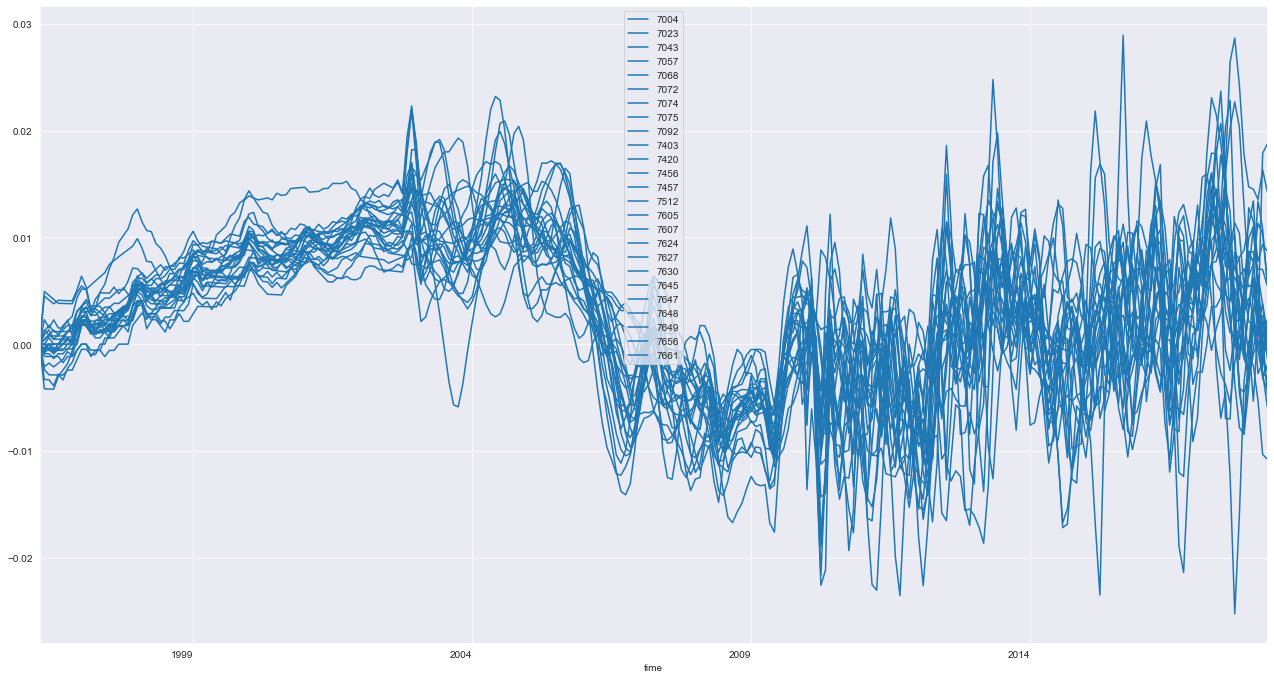

In [101]:
final_df.groupby('zip')['monthly_roi'].plot(figsize=(22,13),subplots=True, legend=True)
plt.show()

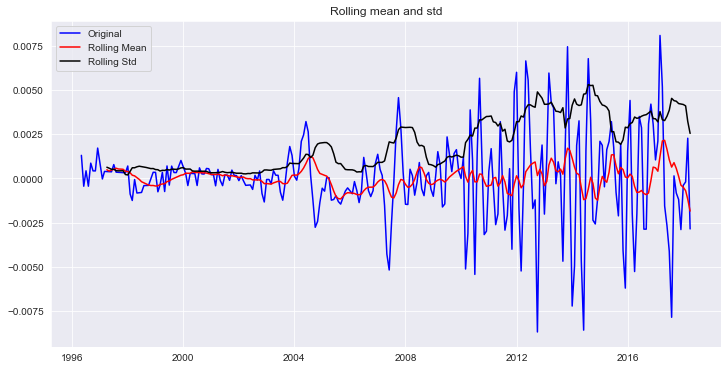

Test Statistic                -6.438429e+00
p-value                        1.630764e-08
#lags used                     1.300000e+01
number of observations used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


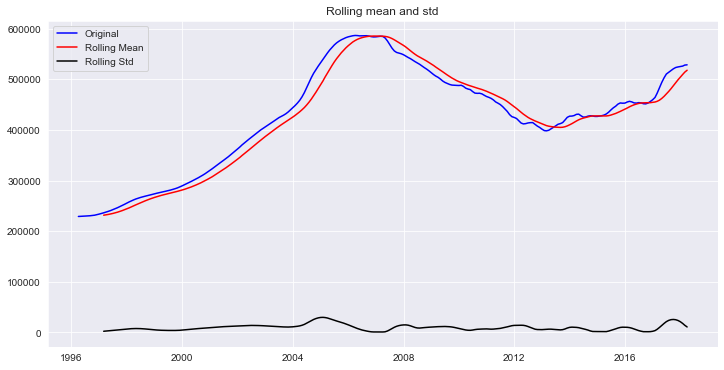

Test Statistic                  -2.317456
p-value                          0.166400
#lags used                      15.000000
number of observations used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [102]:
final_7004 = final_df[final_df.zip == 7004]
stationarity_check(final_7004['monthly_roi'].diff().dropna())
stationarity_check(final_7004['price'])

In [103]:
# result_add = seasonal_decompose(final_7004['roi'], model='multiplicative', extrapolate_trend='freq')
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Multiplicative Decompose', fontsize=22)
# plt.show()

Error. Couldn't train model. Training without invertibility enforcement
                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                  228
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -1992.949
Date:                             Sat, 19 Mar 2022   AIC                           3993.897
Time:                                     10:33:34   BIC                           4007.615
Sample:                                 04-01-1996   HQIC                          3999.432
                                      - 03-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.81e-07  

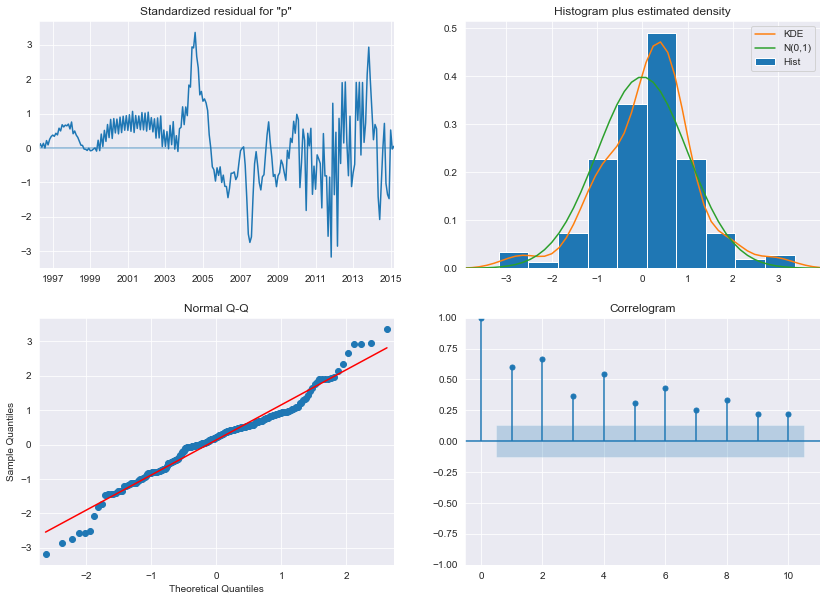

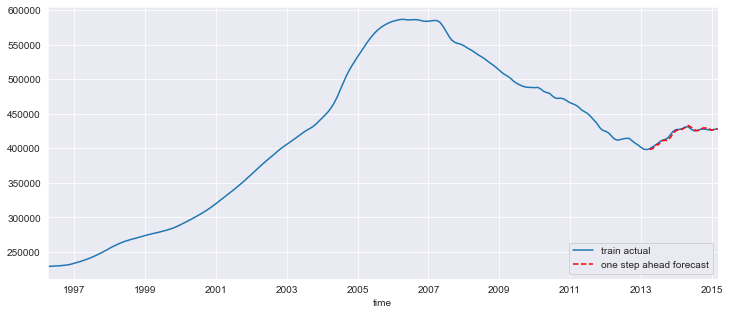

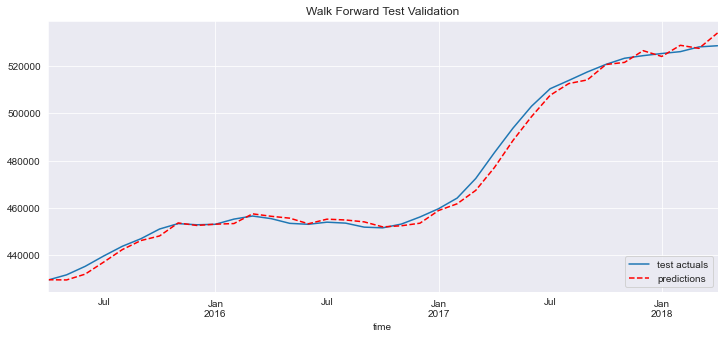

Test RMSE: 2571.7618576722894


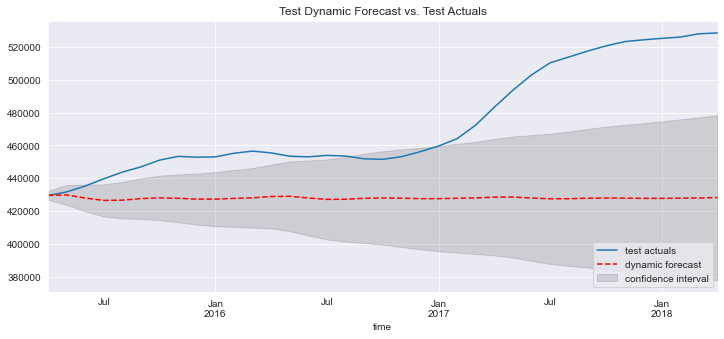

RMSE: 56230.17731665149
Current price: $528600.0, Price after 1 year(s): $571381.71
ROI for 1 year(s):0.08093399603174715

Current price: $528600.0, Price after 3 year(s): $656904.04
ROI for 3 year(s):0.24272425700316663

Current price: $528600.0, Price after 5 year(s): $742414.97
ROI for 5 year(s):0.40449294615711157

Current price: $528600.0, Price after 10 year(s): $956142.89
ROI for 10 year(s):0.8088212030732287



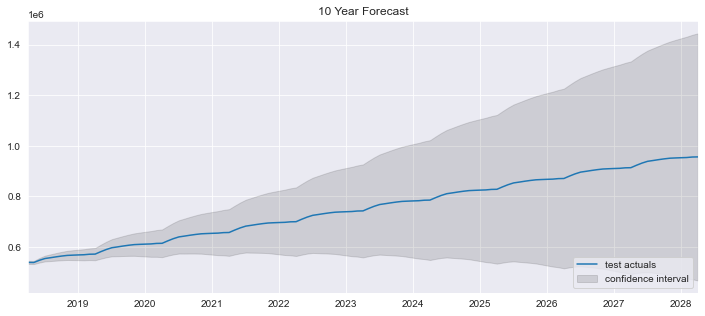

([571381.7103023815, 656904.0422518739, 742414.9713386492, 956142.8879445087],
 [0.08093399603174715,
  0.24272425700316663,
  0.40449294615711157,
  0.8088212030732287])

In [104]:
final_7004 = final_df[final_df.zip == 7004]
train, test = split_train_test(final_7004['price'])

output_df, pdq, PDQS = get_pdqs(train, test, display=False) 
results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=True, diagnostics=True)

# print('\n')
rmse = train_results_rmse(results, train, display=True)
test_results_rmse(train, test, pdq=pdq, PDQS=PDQS)
test_dynamic_predictions(results, test)
forecast_results(final_7004['price'], display=True)

In [105]:
final_df.zip.unique()[:5]

array([7043, 7075, 7647, 7512, 7648], dtype=int64)

In [ ]:
df = final_df[final_df.zip == 7645]['2012':]
train, test = split_train_test(df['price'])
output_df, pdq, PDQS = get_pdqs(train, test, display=True) 
results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=True, diagnostics=True)

# print('\n')
rmse = train_results_rmse(results, train, display=True)
test_results_rmse(train, test, pdq=pdq, PDQS=PDQS)
test_dynamic_predictions(results, test)
forecast_results(df['price'], pdq=pdq, PDQS=PDQS, display=True)

In [132]:
results_df = pd.DataFrame()
# pdqs = []
# PDQS = []

zips = list(final_df.zip.unique())
for z in zips:  # TODO change to all of them 
    # create a df for each zip 
    df = final_df[final_df.zip == z]['2012':] 
    
    # train test split
    train, test = split_train_test(df['price'])
    
    for optimization in ['aic', 'dynamic_rmse']:
        # get the optimal params 
        output_df, pdq, PDQS = get_pdqs(train, test, optimize=optimization, display=False)  
        output_df = output_df.sort_values(by=optimization, ascending=True)
        
        results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
        
        train_results = train_results_rmse(results, train, display=False)
        
        test_results = test_results_rmse(train, test, pdq=pdq, PDQS=PDQS, display=False)

        forecasted_prices, forecasted_rois = forecast_results(df['price'], pdq=pdq, PDQS=PDQS, display=False)
    
        current_df = organize_results(z, output_df, train_results, test_results, forecasted_prices, forecasted_rois)
    
        results_df = pd.concat([results_df, current_df])
    

Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Couldn't train model. Training without invertibility enforcement
Error. Log likelihood 0
Error. Log likelihood 0
Error. Couldn't train model. Training without invertibility enforcement
Error. Log likelihood 0
Error. Couldn't train model. Training without invertibility enforcement
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Couldn't train model. Training without invertibility enforcement
Error. Log likelihood 0
Error. Couldn't train model. Training without invertibility enforcement
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likelihood 0
Error. Log likel

In [133]:
results_df = results_df.set_index('zip')
results_df

,pdq,pdqs,aic,dynamic_rmse,train_rmse,test_rmse,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi
zip,,,,,,,,,,,,,,
7043,"(0, 1, 0)","(0, 1, 0, 12)",512.35,13926.7,4.570877e+03,5.066557e+03,7.611000e+05,7.917000e+05,8.223000e+05,8.988000e+05,2.051488e-02,6.154465e-02,1.025744e-01,2.051488e-01
7043,"(1, 1, 1)","(1, 1, 1, 12)",519.903,13275.6,4.526670e+03,5.042334e+03,7.611077e+05,7.917461e+05,8.224151e+05,8.992212e+05,2.052519e-02,6.160645e-02,1.027288e-01,2.057136e-01
7075,"(0, 1, 0)","(0, 1, 0, 12)",510.349,84515.6,4.354978e+03,3.951154e+03,4.499000e+05,5.383000e+05,6.267000e+05,8.477000e+05,1.089475e-01,3.268425e-01,5.447375e-01,1.089475e+00
7075,"(1, 0, 1)","(1, 0, 0, 12)",698.02,47329.6,1.661267e+03,2.058295e+03,4.072881e+05,4.068538e+05,4.063804e+05,4.051992e+05,3.914583e-03,2.844085e-03,1.677136e-03,-1.234410e-03
7647,"(1, 1, 1)","(0, 1, 1, 12)",508.847,53375,3.780394e+03,4.540540e+03,4.981042e+05,5.627302e+05,6.273764e+05,7.890583e+05,6.935198e-02,2.080941e-01,3.468794e-01,6.939851e-01
7647,"(1, 0, 1)","(1, 1, 1, 12)",987.929,19064.5,1.526983e+04,6.136965e+05,4.708194e+05,4.808067e+05,4.907258e+05,5.152280e+05,1.077583e-02,3.221705e-02,5.351182e-02,1.061142e-01
7512,"(0, 1, 0)","(0, 1, 0, 12)",503.233,61055.2,3.772378e+03,2.886033e+03,4.075000e+05,4.695000e+05,5.315000e+05,6.865000e+05,8.233732e-02,2.470120e-01,4.116866e-01,8.233732e-01
7512,"(1, 0, 1)","(0, 0, 1, 12)",694.245,24382.1,1.258209e+03,1.907967e+03,3.755162e+05,3.752649e+05,3.750585e+05,3.745431e+05,-2.613074e-03,-3.280384e-03,-3.828562e-03,-5.197690e-03
7648,"(0, 1, 0)","(0, 1, 0, 12)",519.007,55382.9,4.867366e+03,4.495012e+03,6.030000e+05,6.998000e+05,7.966000e+05,1.038600e+06,8.727010e-02,2.618103e-01,4.363505e-01,8.727010e-01


In [ ]:
# TODO 

# boolean exogenous in recession variable
# testing on extra 2018 - 2021 data 
# start post recession in 2012 
# go all the way back to 96 and use boolean 

In [59]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/
